In [1]:
import os
os.chdir('/home/ron/Documents/DenseSeg')
print(os.getcwd())

import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from dataset.jsrt_dataset import JSRTDataset, TRAINING_SHAPES

/home/ron/Documents/DenseSeg


# Load and plot data
atlas = mean shape of the training set holding the identity uv grid
sample = example shape from the training set that should obtain the warped uv grid

In [2]:
# Synthetic data
atlas = torch.meshgrid(torch.tensor([1, 3]), torch.tensor([1, 3]), indexing='ij')
atlas = torch.stack(atlas, dim=-1).reshape(-1, 2)

sample = atlas.clone()
sample[-1] = torch.tensor([5, 4])

# scale to make it more image like
scale = 100
atlas *= scale
sample *= scale

# pseudo segmentation mask
seg_mask = torch.zeros(400, 500)
seg_mask[100:, 100:] = 1
seg_mask = seg_mask.bool()

In [3]:
# Real data
anatomy = 'heart'
anatomy_idx = JSRTDataset.get_anatomical_structure_index()[anatomy]
shapes = (TRAINING_SHAPES[:, anatomy_idx[0]:anatomy_idx[1]] + 1) / 2 * 256

idx = 0
atlas = shapes.mean(0)
sample = shapes[idx]
del shapes

_, _, _, seg_mask = JSRTDataset('train')[idx]
seg_mask = seg_mask[list(JSRTDataset.get_anatomical_structure_index().keys()).index(anatomy)].bool()

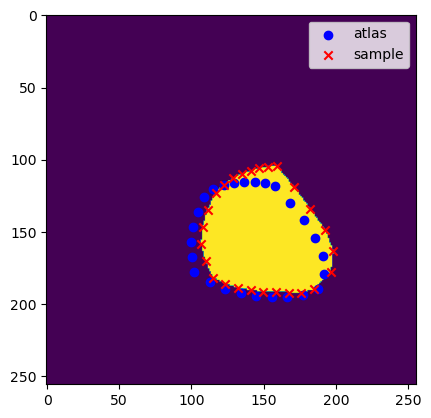

In [4]:
plt.imshow(seg_mask)
plt.scatter(atlas[:, 0], atlas[:, 1], label='atlas', color='b')
plt.scatter(sample[:, 0], sample[:, 1], label='sample', marker='x', color='r')
plt.legend()

# Apply umeyama for rigid alignment of the sample to the atlas. Sample is further referred to as fixed, because we want the warped uv grid of the atlas thus have to registrate the atlas to the fixed.

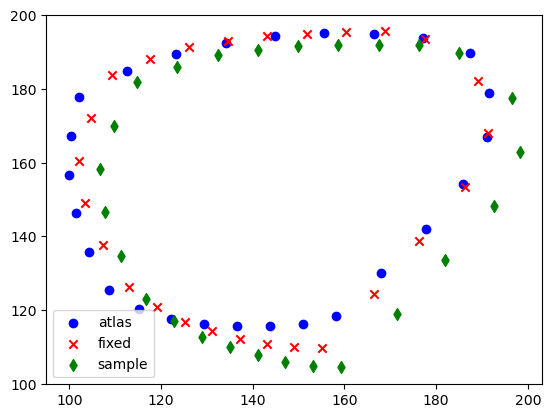

In [5]:
from utils import apply_umeyama_on_tensor

fixed, theta = apply_umeyama_on_tensor(sample, atlas)

plt.scatter(atlas[:, 0], atlas[:, 1], label='atlas', color='b')
plt.scatter(fixed[:, 0], fixed[:, 1], label='fixed', marker='x', color='r')
plt.scatter(sample[:, 0], sample[:, 1], label='sample', marker='d', color='g')
plt.legend()

# Normalize to [-1, 1], so displacements could be used to warp uv coordinates using `F.grid_sample`

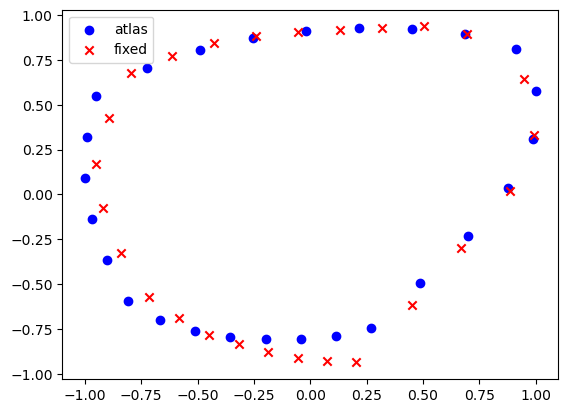

In [6]:
pc = torch.cat([atlas, fixed], dim=0)
range_pc = torch.max(pc, dim=0).values - torch.min(pc, dim=0).values

# normalize
fixed_norm = (fixed - torch.min(pc, dim=0).values) / range_pc.max() # bigger axis [0, 1], smaller axis [0, <1]
fixed_norm = fixed_norm * 2 - (range_pc / range_pc.max()) # bigger axis [-1, 1], smaller axis [>-1, <1] (both centered around 0)

atlas_norm = (atlas - torch.min(pc, dim=0).values) / range_pc.max()
atlas_norm = atlas_norm * 2 - (range_pc / range_pc.max())

pc_norm = torch.cat([atlas_norm, fixed_norm], dim=0)

plt.scatter(atlas_norm[:, 0], atlas_norm[:, 1], label='atlas', color='b')
plt.scatter(fixed_norm[:, 0], fixed_norm[:, 1], label='fixed', marker='x', color='r')
plt.legend()

# Registration

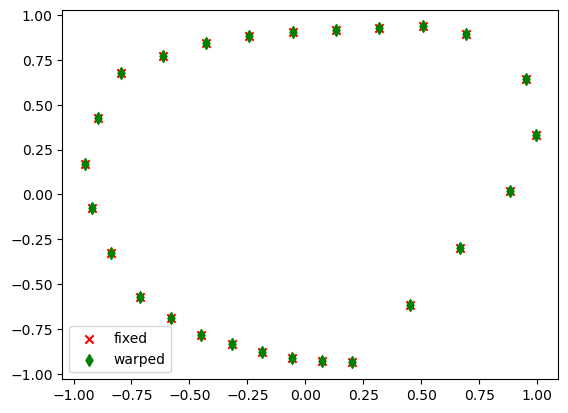

In [7]:
displacement = fixed_norm - atlas_norm
warped_atlas = atlas_norm + displacement

plt.scatter(fixed_norm[:, 0], fixed_norm[:, 1], label='fixed', marker='x', color='r')
plt.scatter(warped_atlas[:, 0], warped_atlas[:, 1], label='warped', marker='d', color='g')
plt.legend()

## Plot displacements

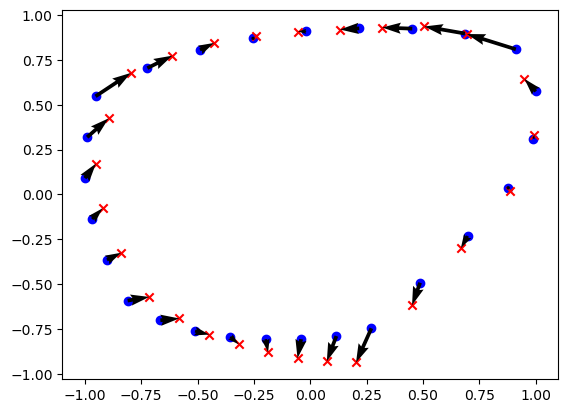

In [8]:
plt.scatter(atlas_norm[:, 0], atlas_norm[:, 1], label='atlas', color='b')
plt.scatter(fixed_norm[:, 0], fixed_norm[:, 1], label='fixed', marker='x', color='r')
plt.quiver(atlas_norm[:, 0], atlas_norm[:, 1], displacement[:, 0], displacement[:, 1], angles='xy', scale_units='xy', scale=1)

# Interpolate to dense displacement field

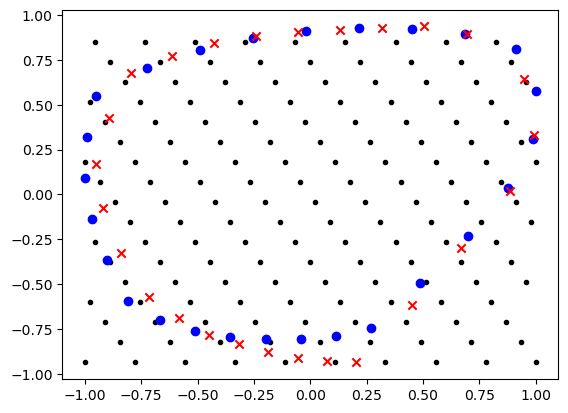

In [9]:
# bounding box
bb_min = torch.min(pc_norm, dim=0).values
bb_max = torch.max(pc_norm, dim=0).values
range_pc_int = range_pc.floor().int()

# create grid for bounding box keeping the same amount of "pixel" as in the image
grid = torch.meshgrid(torch.linspace(bb_min[0], bb_max[0], range_pc_int[0]), torch.linspace(bb_min[1], bb_max[1], range_pc_int[1]), indexing='ij')
grid = torch.stack(grid, dim=-1).reshape(-1, 2)

# sparse plotting (every 50th point)
plt.scatter(grid[::50, 0], grid[::50, 1], color='k', marker='.')
plt.scatter(atlas_norm[:, 0], atlas_norm[:, 1], label='atlas', color='b')
plt.scatter(fixed_norm[:, 0], fixed_norm[:, 1], label='fixed', marker='x', color='r')

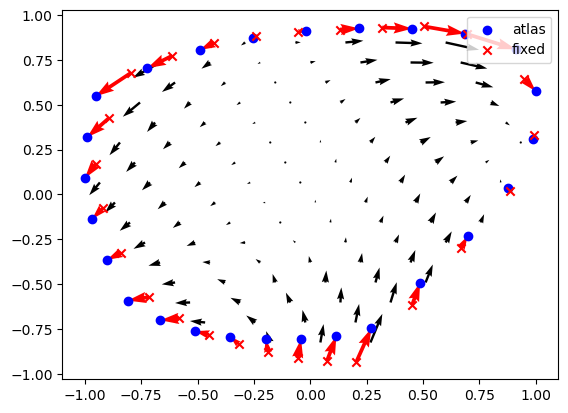

In [10]:
# bilinear interpolation
grid_displacement = griddata(fixed_norm, -displacement, grid, method='linear', rescale=True)
grid_displacement = torch.from_numpy(grid_displacement).float()

# sparse plotting (every 50th point)
plt.quiver(grid[::50, 0], grid[::50, 1], grid_displacement[::50, 0], grid_displacement[::50, 1], angles='xy', scale_units='xy', scale=1)
plt.quiver(fixed_norm[:, 0], fixed_norm[:, 1], -displacement[:, 0], -displacement[:, 1], angles='xy', scale_units='xy', scale=1, color='r')
plt.scatter(atlas_norm[:, 0], atlas_norm[:, 1], label='atlas', color='b')
plt.scatter(fixed_norm[:, 0], fixed_norm[:, 1], label='fixed', marker='x', color='r')
plt.legend()

Find indices of the atlas in the grid.

In [11]:
# bounding box for atlas
range_atlas = torch.max(atlas, dim=0).values - torch.min(atlas, dim=0).values
range_atlas_int = range_atlas.floor().int()

# finding the starting point of the atlas in the grid
atlas_grid_start = torch.norm(grid.view(-1, 2) - atlas_norm.min(0).values, dim=-1).argmin()
atlas_grid_start = torch.tensor([atlas_grid_start // range_pc_int[1], atlas_grid_start % range_pc_int[1]])
atlas_grid_end = atlas_grid_start + range_atlas_int

Place dummy image at grid covering the atlas. Dummy image because it is easier to see the effect of the displacement.

/home/ron/mambaforge/envs/DenseBone/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


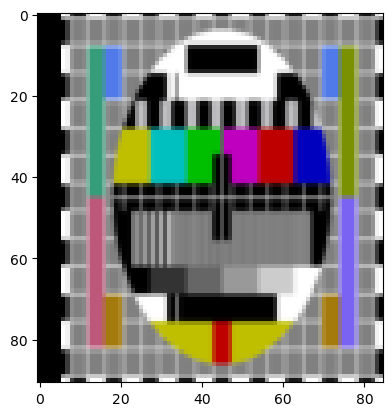

In [12]:
from torchvision.io import read_image
from torchvision.transforms import Resize

tmp_img = read_image('dev/test_img.png')
tmp_img = Resize(range_atlas_int.tolist())(tmp_img) / 255

grid_img = torch.full((3, range_pc_int[0], range_pc_int[1]), torch.nan)
grid_img[:, atlas_grid_start[0]:atlas_grid_end[0], atlas_grid_start[1]:atlas_grid_end[1]] = tmp_img

plt.imshow(grid_img.permute(1, 2, 0))

Warp the grid using the displacement field and grid_sample.

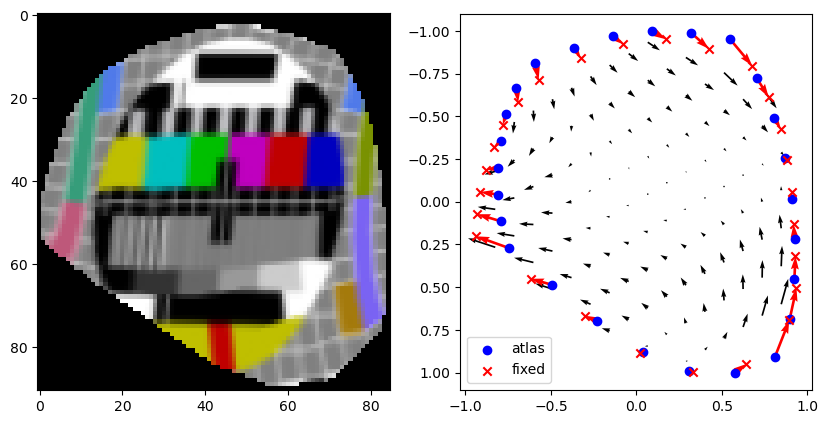

In [13]:
warped_grid = grid + grid_displacement
warped_grid_img = F.grid_sample(grid_img.unsqueeze(0), warped_grid.view(1, range_pc_int[0], range_pc_int[1], 2).flip(-1), mode='bilinear', padding_mode='zeros', align_corners=True).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(warped_grid_img.permute(1, 2, 0))

idx = 50
ax[1].quiver(grid[::idx, 1], grid[::idx, 0], -grid_displacement[::idx, 1], -grid_displacement[::idx, 0], angles='xy', scale_units='xy', scale=1)
ax[1].quiver(atlas_norm[:, 1], atlas_norm[:, 0], displacement[:, 1], displacement[:, 0], angles='xy', scale_units='xy', scale=1, color='r')
ax[1].scatter(atlas_norm[:, 1], atlas_norm[:, 0], label='atlas', color='b')
ax[1].scatter(fixed_norm[:, 1], fixed_norm[:, 0], label='fixed', marker='x', color='r')
ax[1].legend()
ax[1].invert_yaxis()
ax[1].set_aspect('equal')
del idx


## Now repeat the process for the actual uv grid

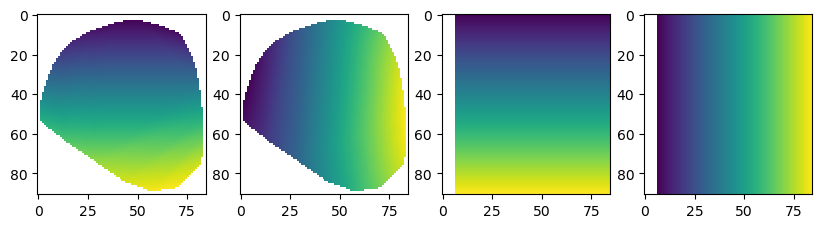

In [14]:
# uv map
uv = torch.meshgrid(
    torch.linspace(-1, 1, range_atlas_int[0]),
    torch.linspace(-1, 1, range_atlas_int[1]),
    indexing='ij'
)
uv = torch.stack(uv, dim=0)

uv_grid = torch.full((2, range_pc_int[0], range_pc_int[1]), torch.nan)
uv_grid[:, atlas_grid_start[0]:atlas_grid_end[0], atlas_grid_start[1]:atlas_grid_end[1]] = uv

warped_uv_grid = F.grid_sample(uv_grid.unsqueeze(0), warped_grid.view(1, range_pc_int[0], range_pc_int[1], 2).flip(-1), mode='bilinear', padding_mode='zeros', align_corners=True).squeeze(0)
fig, ax = plt.subplots(1, 4, figsize=(10, 10))
ax[0].imshow(warped_uv_grid[0])
ax[1].imshow(warped_uv_grid[1])

ax[2].imshow(uv_grid[0])
ax[3].imshow(uv_grid[1])

# Place warped uv grid back into the image space
Finding area of our point cloud in the image space and put the warped uv grid in that area.

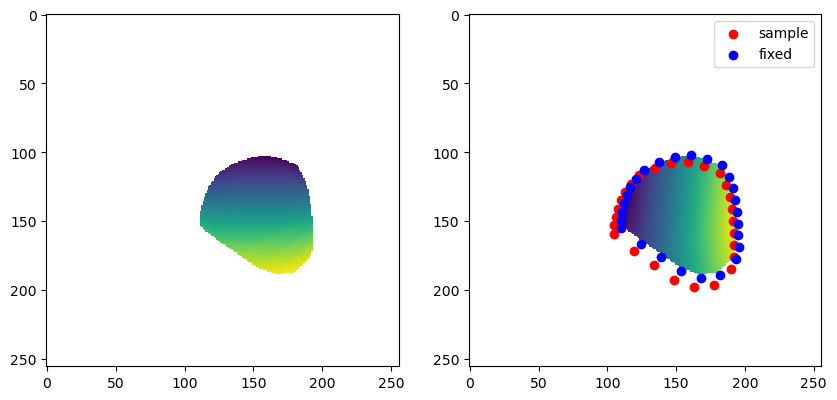

In [15]:
img_size = seg_mask.shape[::-1]
pc_bbox_min = torch.min(pc, dim=0).values.round().int()
pc_bbox_max = torch.tensor(warped_uv_grid.shape[-2:]) + pc_bbox_min

uv_img_space = torch.full((2, img_size[0], img_size[1]), torch.nan)
uv_img_space[:, pc_bbox_min[0]:pc_bbox_max[0], pc_bbox_min[1]:pc_bbox_max[1]] = warped_uv_grid

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(uv_img_space[0])

ax[1].imshow(uv_img_space[1])
ax[1].scatter(sample[:, 1], sample[:, 0], color='r', label='sample')
ax[1].scatter(fixed[:, 1], fixed[:, 0], color='b', label='fixed')
ax[1].legend()

Reverse the rigid alignment to get the warped uv grid from the position of the fixed shape to the sample shape. 

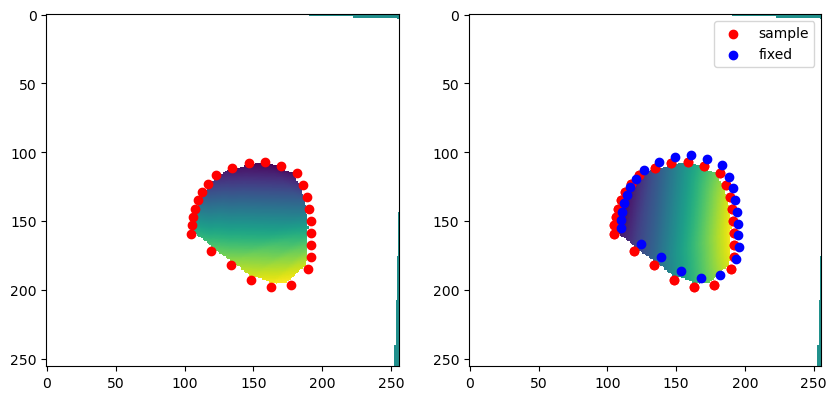

In [16]:
from kornia.geometry import warp_affine, invert_affine_transform

theta_23 = theta[:2, :].clone().unsqueeze(0)
theta_23_inv = invert_affine_transform(theta_23)

uv_img_space_corrected = warp_affine(uv_img_space.unsqueeze(0), theta_23_inv, dsize=(img_size[0], img_size[1]), align_corners=True).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(uv_img_space_corrected[0])
ax[0].scatter(sample[:, 1], sample[:, 0], color='r')

ax[1].imshow(uv_img_space_corrected[1])
ax[1].scatter(sample[:, 1], sample[:, 0], color='r')
ax[1].scatter(sample[:, 1], sample[:, 0], color='r', label='sample')
ax[1].scatter(fixed[:, 1], fixed[:, 0], color='b', label='fixed')
ax[1].legend()

Text(0.5, 1.0, 'Kornia Inverse')

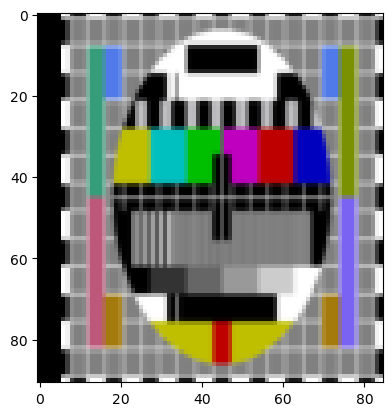

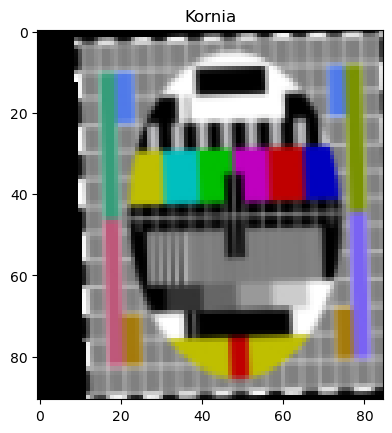

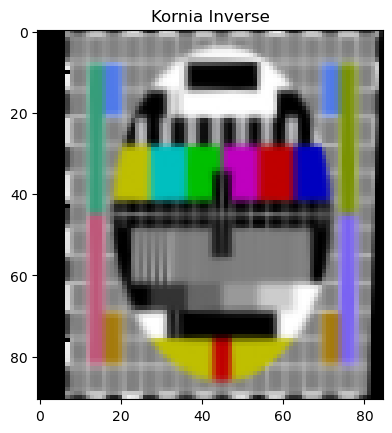

In [17]:
# some debugging
plt.imshow(grid_img.permute(1, 2, 0))

kornia_img = warp_affine(grid_img.unsqueeze(0), theta_23, dsize=(grid_img.shape[-2], grid_img.shape[-1]), align_corners=True).squeeze()
plt.figure()
plt.imshow(kornia_img.permute(1, 2, 0))
plt.title('Kornia')

kornia_img_inv = warp_affine(kornia_img.unsqueeze(0), theta_23_inv, dsize=(grid_img.shape[-2], grid_img.shape[-1]), align_corners=True).squeeze()

plt.figure()
plt.imshow(kornia_img_inv.permute(1, 2, 0))
plt.title('Kornia Inverse')

Mask the uv grid utilizing the segmentation mask thus only the uv grid in the area of the object is visible. Due to the interpolation of the displacement field covering the convex hull of the point cloud, the uv grid could also be outside the object.

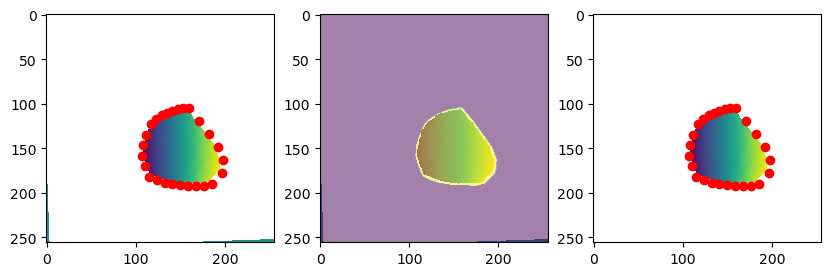

In [18]:
uv_img_space_masked = uv_img_space_corrected.clone().transpose(1, 2)
uv_img_space_masked[:, seg_mask.logical_not()] = torch.nan

fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].scatter(sample[:, 0], sample[:, 1], color='r')
axs[0].imshow(uv_img_space_corrected[0].t())

axs[1].imshow(uv_img_space_corrected[0].t())
axs[1].imshow(seg_mask, alpha=0.5)

axs[2].imshow(uv_img_space_masked[0])
axs[2].scatter(sample[:, 0], sample[:, 1], color='r')

# UV coordinates of atlas

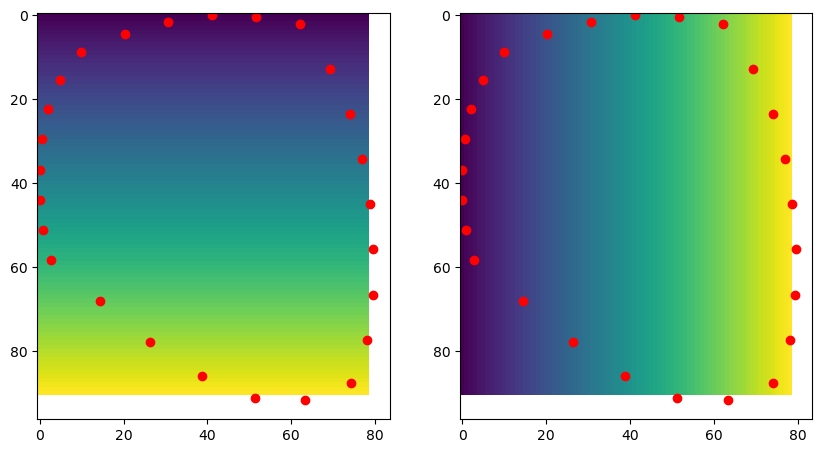

In [19]:
atlas_tmp = atlas - torch.min(atlas, dim=0).values

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(uv[0])
axs[0].scatter(atlas_tmp[:, 1], atlas_tmp[:, 0], color='r')

axs[1].imshow(uv[1])
axs[1].scatter(atlas_tmp[:, 1], atlas_tmp[:, 0], color='r')

In [20]:
# atlas to [-1, 1]
atlas_grid_sample = (atlas - torch.min(atlas, dim=0).values) / range_atlas
atlas_grid_sample = atlas_grid_sample * 2 - 1

atlas_uv_values = F.grid_sample(uv.unsqueeze(0), atlas_grid_sample.view(1, 1, -1, 2).flip(-1), mode='bilinear', padding_mode='zeros', align_corners=True).squeeze()

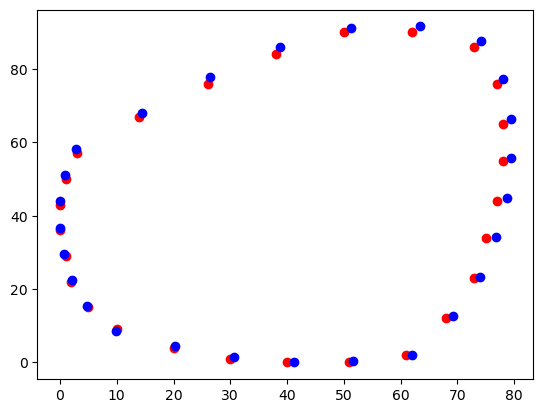

In [21]:
# found atlas uv coordinates
atlas_uv_coords_dist = uv.view(2, -1, 1) - atlas_uv_values.view(2, 1, -1)
atlas_uv_coords_dist = torch.linalg.vector_norm(atlas_uv_coords_dist, dim=0)

atlas_uv_coords = atlas_uv_coords_dist.argmin(dim=0)
atlas_uv_coords = torch.stack([atlas_uv_coords // uv.shape[2], atlas_uv_coords % uv.shape[2]], dim=-1)

plt.scatter(atlas_uv_coords[:, 1], atlas_uv_coords[:, 0], color='r')
plt.scatter(atlas_tmp[:, 1], atlas_tmp[:, 0], color='b')